In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [3]:
passengers.head()

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
passengers["num_passengers"] *= 1000

In [5]:
passengers.head()

,num_passengers
date,
1949-01-01,112000
1949-02-01,118000
1949-03-01,132000
1949-04-01,129000
1949-05-01,121000


In [6]:
def boxcox(data, lambda_):
    return np.log(data) if lambda_ == 0 else (data**lambda_-1)/lambda_

In [7]:
def func(data, lambda_):
    T = data.shape[0]
    return T/2*np.log(np.sum((boxcox(data,lambda_)-np.mean(boxcox(data,lambda_)))**2)/T)-(lambda_-1)*np.sum(np.log(data))

In [8]:
optimization = minimize(lambda x: func(passengers["num_passengers"], x[0]), (0))

print(optimization)
lambda_ = optimization.x

      fun: 1674.259891341842
 hess_inv: array([[0.03867317]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.14802283])


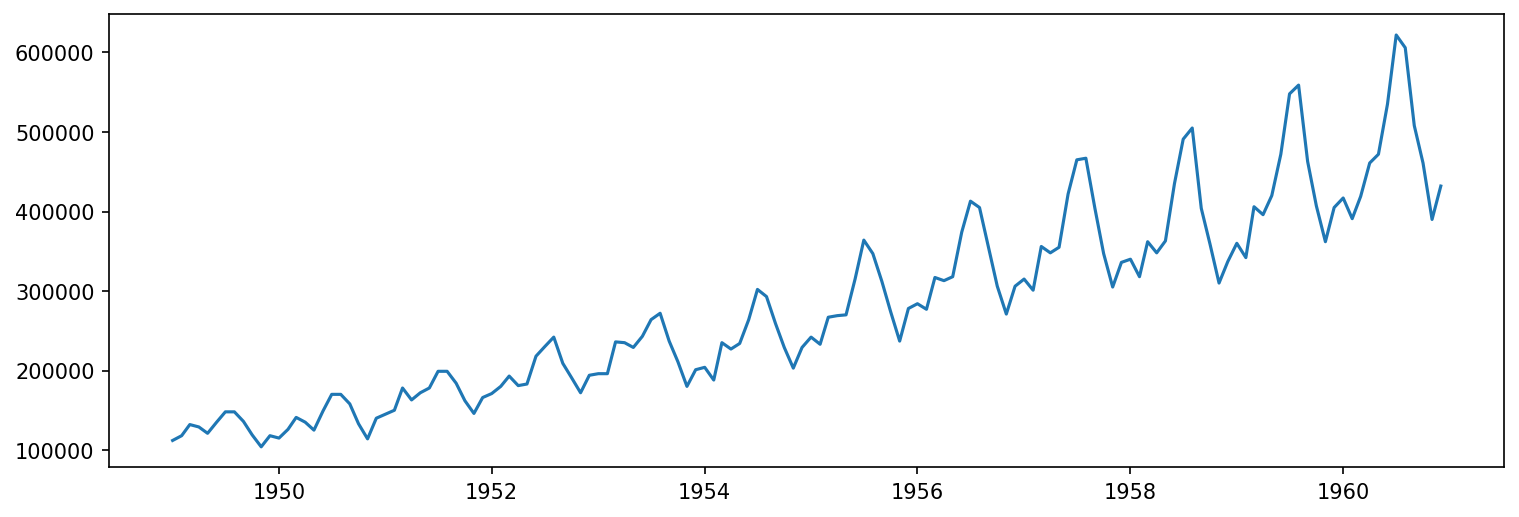

In [9]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["num_passengers"])
plt.show()

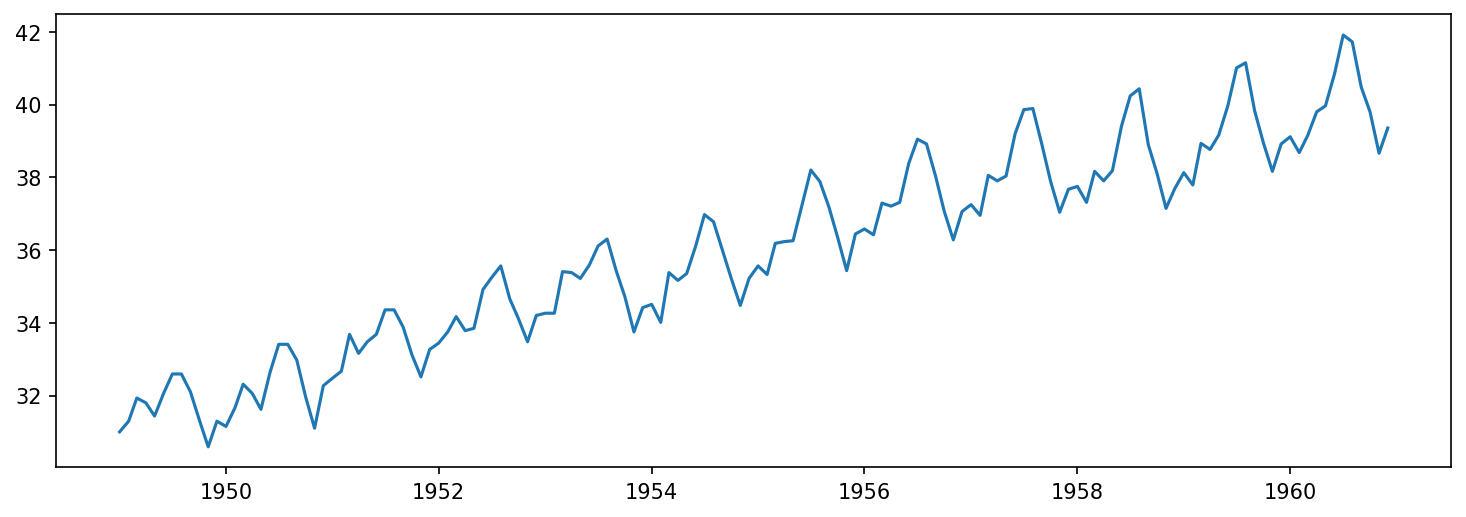

In [10]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(boxcox(passengers["num_passengers"], lambda_))
plt.show()

In [11]:
data = passengers["num_passengers"]

In [12]:
data

date
1949-01-01    112000
1949-02-01    118000
1949-03-01    132000
1949-04-01    129000
1949-05-01    121000
               ...  
1960-08-01    606000
1960-09-01    508000
1960-10-01    461000
1960-11-01    390000
1960-12-01    432000
Name: num_passengers, Length: 144, dtype: int64

In [13]:
def diff(data, lag):
    return [data[t]-data[t-lag] for t in range(lag, len(data))]

In [14]:
bc = boxcox(passengers["num_passengers"], lambda_)

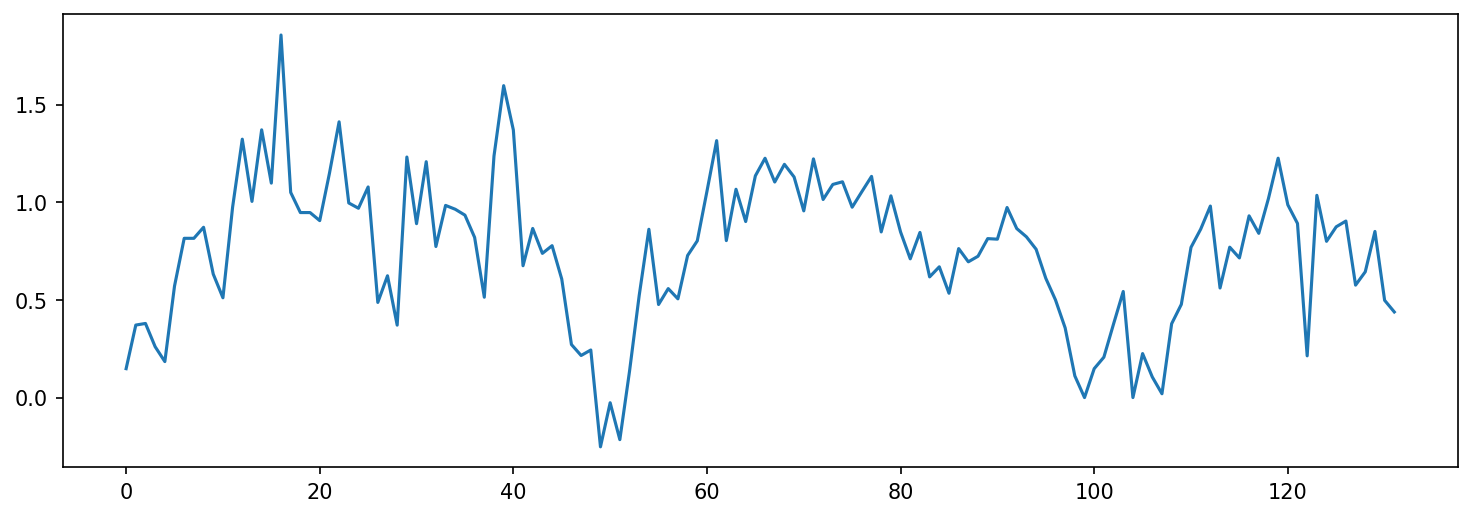

In [15]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(diff(bc, 12))
plt.show()

## SARIMA

### Модель AR

In [16]:
passengers.columns = ["y"]

In [17]:
data_diff = diff(diff(boxcox(passengers["y"], lambda_), 12), 1)

In [18]:
data_diff

[0.22327455326481171,
 0.00829986733005228,
 -0.11924726401290187,
 -0.07603957392714022,
 0.38684632636126537,
 0.24445946264265928,
 0.0,
 0.05658198630162303,
 -0.23969165704282247,
 -0.1214752629923872,
 0.4642705967437166,
 0.3480622020617936,
 -0.31873114288195836,
 0.3665830219401407,
 -0.27290873514188974,
 0.7585981808371614,
 -0.8061755738170291,
 -0.10321633432369026,
 0.0,
 -0.04130078157928807,
 0.24142332653897824,
 0.2646432347999408,
 -0.4156100718262792,
 -0.02705121973588831,
 0.10903414792975497,
 -0.5914068286238816,
 0.13651526691818106,
 -0.25284357148462533,
 0.8610068764079273,
 -0.34130240721110283,
 0.31743640871375334,
 -0.43437096012061005,
 0.210445518981075,
 -0.019734206516432096,
 -0.030139478134600495,
 -0.11398206918543252,
 -0.30641727854184353,
 0.7231068168901231,
 0.36059202950756486,
 -0.2270307784904233,
 -0.6953974052265224,
 0.190942166275768,
 -0.1275610860067573,
 0.039456783273529084,
 -0.1711008195655097,
 -0.3351899934743159,
 -0.056209207

In [19]:
df = pd.DataFrame(data_diff, columns=["y"])

In [20]:
df

,y
0,0.223275
1,0.008300
2,-0.119247
3,-0.076040
4,0.386846
...,...
126,-0.328126
127,0.068154
128,0.206691
129,-0.352616


In [21]:
df["y1"] = df["y"].shift(1)
df["y2"] = df["y"].shift(2)
df["y3"] = df["y"].shift(3)
df["y12"] = df["y"].shift(12)

In [22]:
df.head()

,y,y1,y2,y3,y12
0,0.223275,NaN,NaN,NaN,NaN
1,0.008300,0.223275,NaN,NaN,NaN
2,-0.119247,0.008300,0.223275,NaN,NaN
3,-0.076040,-0.119247,0.008300,0.223275,NaN
4,0.386846,-0.076040,-0.119247,0.008300,NaN


In [23]:
df = df.dropna()

In [24]:
df.head()

,y,y1,y2,y3,y12
12,-0.318731,0.348062,0.464271,-0.121475,0.223275
13,0.366583,-0.318731,0.348062,0.464271,0.008300
14,-0.272909,0.366583,-0.318731,0.348062,-0.119247
15,0.758598,-0.272909,0.366583,-0.318731,-0.076040
16,-0.806176,0.758598,-0.272909,0.366583,0.386846


In [25]:
def mse(data, phi1, phi2, phi3, phi12, alpha):
    return np.mean((data["y"] - (alpha + phi1*data["y1"] + phi2*data["y2"] + phi3*data["y3"] + phi12*data["y12"]))**2)

In [26]:
opfunc = lambda x: mse(df, x[0], x[1], x[2], x[3], x[4])

optimization = minimize(opfunc, (0, 0, 0, 0, 0))

print(optimization)
phi1, phi2, phi3, phi12, alpha = optimization.x

      fun: 0.057125606038142485
 hess_inv: array([[ 6.36844325,  2.28496262,  0.13403173,  0.22147159,  0.0166561 ],
       [ 2.28496262,  7.26107487,  2.35370738,  0.10455558,  0.04968519],
       [ 0.13403173,  2.35370738,  6.57132136, -1.1850196 ,  0.09001846],
       [ 0.22147159,  0.10455558, -1.1850196 ,  6.51284029, -0.04908085],
       [ 0.0166561 ,  0.04968519,  0.09001846, -0.04908085,  0.48247485]])
      jac: array([ 5.42029738e-07, -9.17352736e-08, -3.63215804e-07, -4.64264303e-07,
        7.42729753e-07])
  message: 'Optimization terminated successfully.'
     nfev: 108
      nit: 17
     njev: 18
   status: 0
  success: True
        x: array([-0.37053232, -0.06531136, -0.08831013, -0.39043012, -0.00519   ])


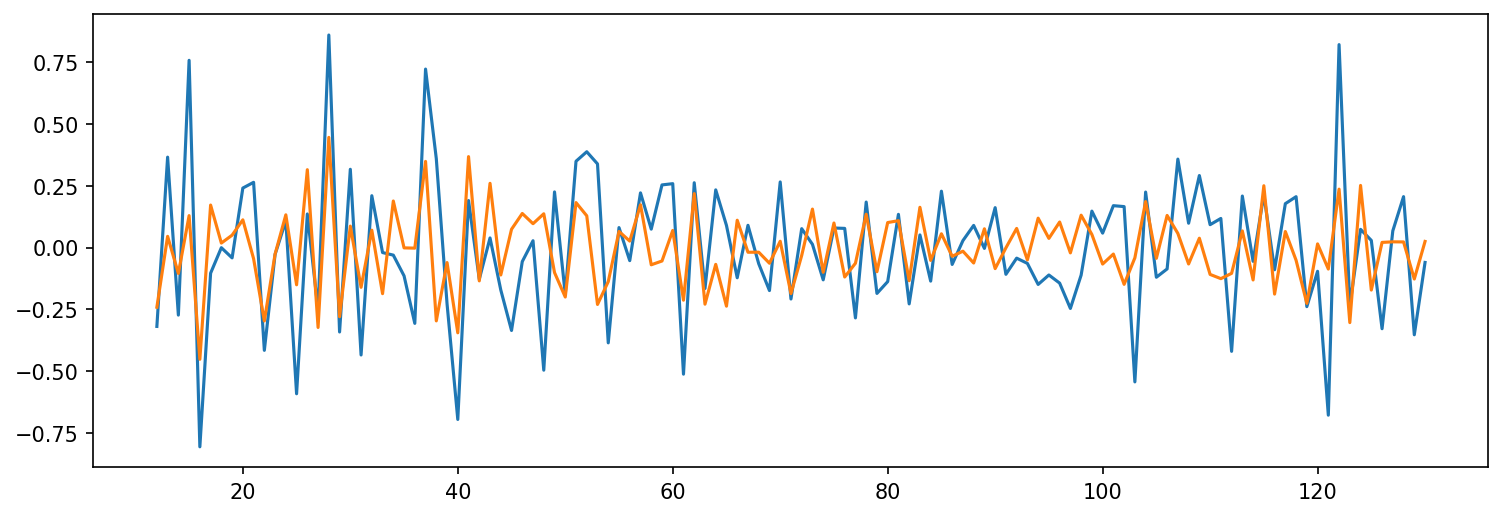

In [27]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"])
plt.plot(alpha + phi1*df["y1"] + phi2*df["y2"] + phi3*df["y3"] + phi12*df["y12"])
plt.show()

### Модель MA

In [28]:
ar = alpha + phi1*df["y1"] + phi2*df["y2"] + phi3*df["y3"] + phi12*df["y12"]

In [29]:
df["eps"] = df["y"] - ar

/tmp/ipykernel_1962659/489818192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["eps"] = df["y"] - ar


In [30]:
df["eps1"] = df["eps"].shift(1)
df["eps2"] = df["eps"].shift(2)

/tmp/ipykernel_1962659/2348399662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["eps1"] = df["eps"].shift(1)
/tmp/ipykernel_1962659/2348399662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["eps2"] = df["eps"].shift(2)


In [31]:
data = df.dropna()

In [32]:
def mse(data, theta1, theta2, alpha):
    return np.mean((data["eps"] - (alpha + theta1*data["eps1"] + theta2*data["eps2"]))**2)

In [33]:
func = lambda x: mse(data, x[0], x[1], x[2])

optimization = minimize(func, (0, 0, 0))

print(optimization)
theta1, theta2, alpha2 = optimization.x

      fun: 0.056922041330531734
 hess_inv: array([[ 8.08570153,  0.54870747, -0.03474096],
       [ 0.54870747,  7.97757247,  0.0955651 ],
       [-0.03474096,  0.0955651 ,  0.47917143]])
      jac: array([ 1.95112079e-07, -1.36764720e-06,  3.95905226e-06])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([-0.06483191, -0.01154833, -0.00195308])


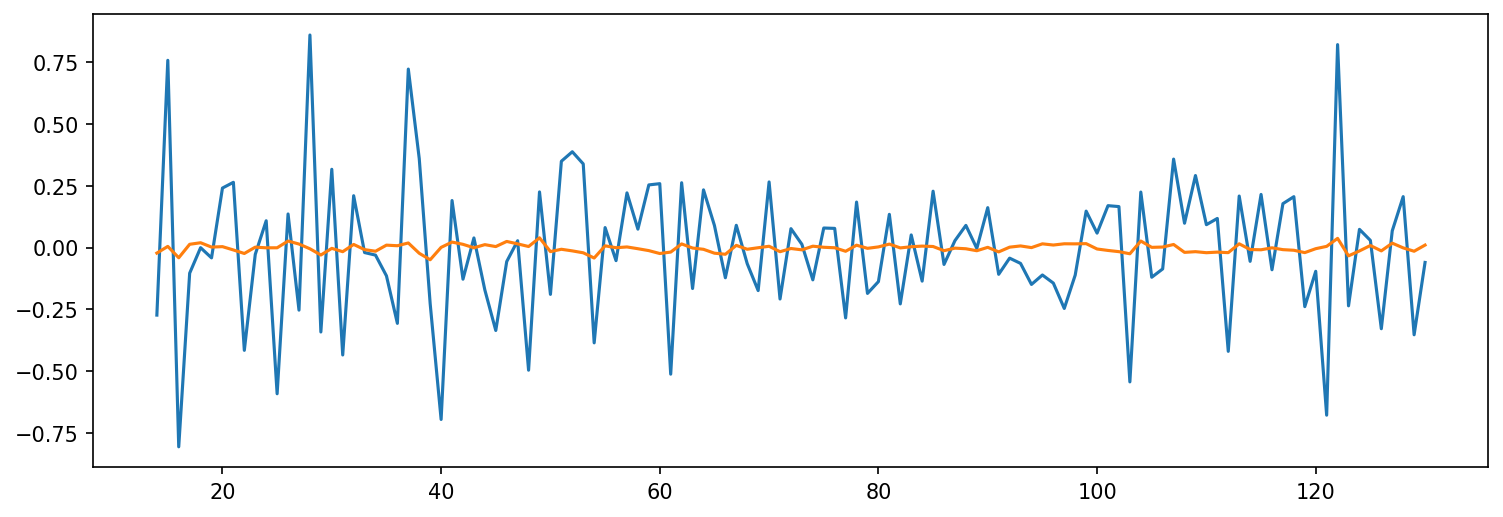

In [34]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(data["y"])
plt.plot(alpha2 + theta1*data["eps1"] + theta2*data["eps2"])
plt.show()

In [35]:
arma = (alpha+alpha2) + phi1*data["y1"] + phi2*data["y2"] + phi3*data["y3"] + phi12*data["y12"] + theta1*data["eps1"] + theta2*data["eps2"]

### Модель SARIMA

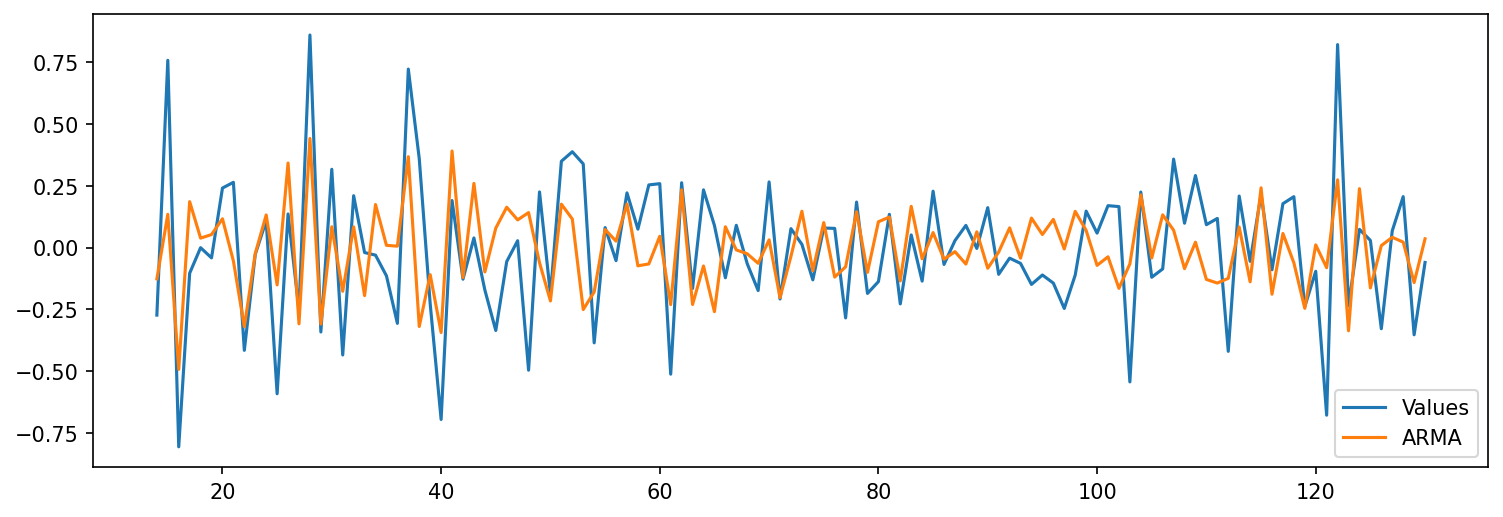

In [36]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(data["y"], label="Values")
#plt.plot(ar, label="AR")
plt.plot(arma, label="ARMA")
plt.legend()
plt.show()

### MSE

In [37]:
mse_arma = np.mean((df["y"] - arma)**2)

In [38]:
mse_ar = np.mean((data["y"] - ar)**2)

In [39]:
print(f"MSE ARMA: {mse_arma}")
print(f"MSE AR: {mse_ar}")
print(f"Difference: {mse_ar-mse_arma}")

MSE ARMA: 0.05692204133053173
MSE AR: 0.05717162315651702
Difference: 0.00024958182598529277


## Прогноз

In [40]:
arma

14    -0.126226
15     0.135095
16    -0.492632
17     0.186392
18     0.038738
         ...   
126    0.008477
127    0.042116
128    0.022495
129   -0.141183
130    0.035877
Length: 117, dtype: float64

In [57]:
forecast = list(arma.values)

for t in range(12):
    forecast.append((alpha+alpha2) + phi1*forecast[-1] + phi2*forecast[-2] + phi3*forecast[-3] + phi12*forecast[-12] + theta1*forecast[-1] + theta2*forecast[-2])
    
forecast = np.array(forecast)

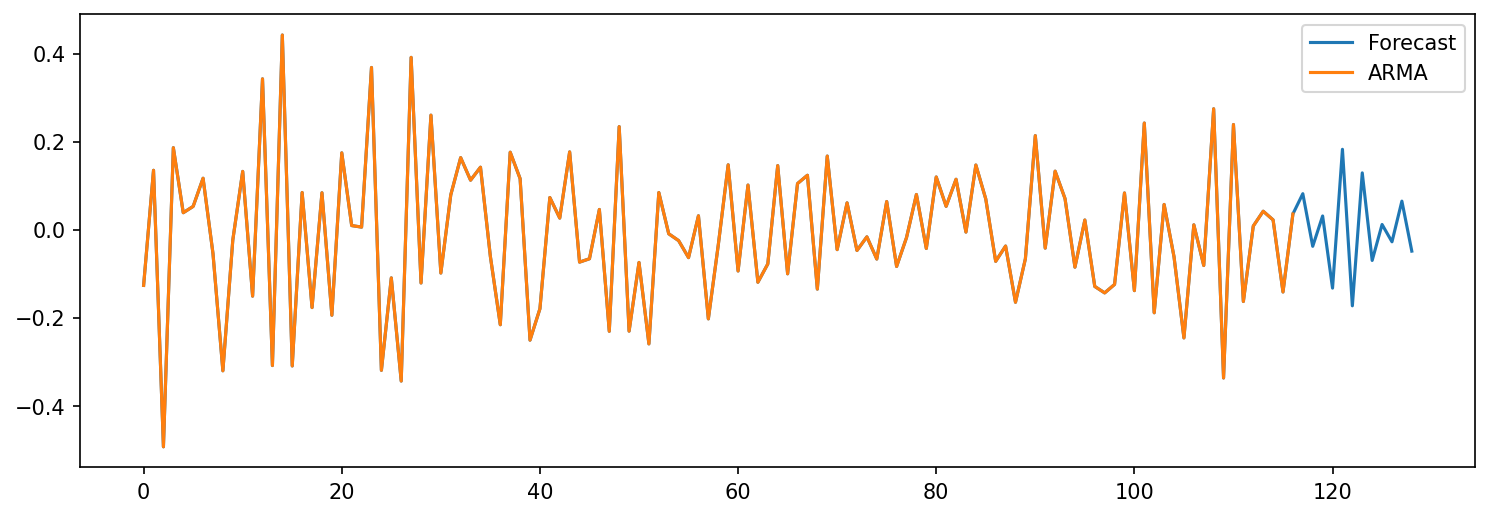

In [79]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(forecast, label="Forecast")
plt.plot(arma.values, label="ARMA")
plt.legend()
plt.show()

In [105]:
forecast[-12]

0.08192316111138281

In [99]:
boxcox_data = boxcox(passengers["y"], lambda_)
seasonal_diff_data = diff(boxcox(passengers["y"], lambda_), 12)
diff_data = diff(diff(boxcox(passengers["y"], lambda_), 12), 1)

In [100]:
seasonal_forecast = seasonal_diff_data

for t in range(12):
    seasonal_forecast.append(forecast[-(12+t)]+seasonal_forecast[-1])

In [70]:
def invboxcox(x, lambda_):
    return np.exp(x) if lambda_ == 0 else (lambda_*x+1)**(1/lambda_)

In [72]:
invboxcox(forecast[-12]+seasonal_diff_data[-1], lambda_)

array([1.65088398])